### University of Washington: Machine Learning and Statistics 

# Lecture 1:  Regression (linear, errors on variables, outliers)


Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 8. 
- [astroML website](https://www.astroml.org/index.html)

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, and many others.

The notebook and assoociated material are available from [github](https://github.com/uw-astro/astr-598a-win22).

Make sure you are using the latest version of Jupyterlab (>3.0)
> pip install jupyterlab --upgrade

### Installing the latest (v1.0) of astroML from git

> pip install --pre -U astroml

<a id='toc'></a>

## This notebook includes:

[Ordinary least squares method](#ordinaryLSQ)

[Total least squares method](#totalLSQ) 

[Dealing witth Outliers](#outliers)


### Fitting a Line using a Maximum Likelihood Estimator


Assume the scatter in our measurements (the residuals) is generated by a gaussian process. I.e.:

>$ y_i = m x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

Let us compute the likelihood. First, we ask ourselves what is the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured (M is our model). It is just the normal distribution:

>$ p(y_i|x_i, M(m, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

We can write down the $\ln L$

>$ \ln L(m, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $m$ and $b$ to find ML estimators for those parameters. This is equivalent to minimizing the sum of the squares or a _least-squares method_

## Ordinary least squares method <a id='ordinaryLSQ'></a>
[Go to top](#toc)

### NOTE: We  suppress warnings for the packages (this is not recommended) 

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib
matplotlib.rc('text', usetex=False)
import seaborn as sns
from scipy import optimize

from astroML.linear_model import TLS_logL
from astroML.plotting import setup_text_plots
from astroML.plotting.mcmc import convert_to_stdev
setup_text_plots(fontsize=8, usetex=True)
# random seed 
np.random.seed(42)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# We'll use the data from Table 1 of Hogg et al. 2010
from astroML.datasets import fetch_hogg2010test  
data = fetch_hogg2010test()
data = data[5:]  # no outliers (the first 5 points are outliers, discussed later)
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']
y_obs = y

(100.0, 600.0)

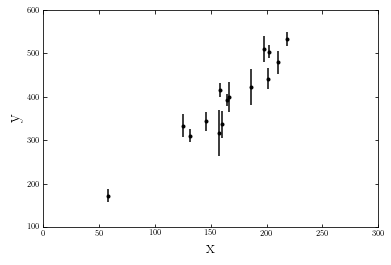

In [4]:
# Plot the data with y error bars
plt.errorbar(x, y, yerr=sigma_y, fmt=".k", capsize=0) 
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.xlim(0, 300)
plt.ylim(100, 600)

### We have data $y(x)$ and we want to fit this model (i.e. we want to obtain m and b):

$$\mathbf{y} = m \, \mathbf{x} + b$$


For this problem the maximum likelihood and full posterior probability distribution (under infinitely broad priors) for the slope and intercept of the line are known analytically. The analytic result for the posterior probability distribution is a 2-d Gaussian with mean

$$\mathbf{w} = \left(\begin{array}{c}
    m \\ b
\end{array}\right) = (\mathbf{A}^\mathrm{T}\,C^{-1}\mathbf{A})^{-1} \, \mathbf{A}^\mathrm{T}\,C^{-1}\,\mathbf{y}$$

and covariance matrix

$$\mathbf{V} = (\mathbf{A}^\mathrm{T}\,C^{-1}\mathbf{A})^{-1}$$

where

$$\mathbf{y} = \left(\begin{array}{c}
y_1 \\ y_2 \\ \vdots \\ y_N
\end{array}\right) \quad , \quad \mathbf{A} = \left(\begin{array}{cc}
x_1 & 1 \\ x_2 & 1 \\ \vdots & \vdots \\ x_N & 1
\end{array}\right) \quad,\, \mathrm{and} \quad
\mathbf{C} = \left(\begin{array}{cccc}
\sigma_1^2 & 0 & \cdots & 0 \\
0 & \sigma_2^2 & \cdots & 0 \\
&&\ddots& \\
0 & 0 & \cdots & \sigma_N^2
\end{array}\right)$$

Sometimes we call $A$ the design matrix. There are various functions in Python (and astroML/scikit-learn) for computing this but let's do it explicitly and step by step. With numpy, it only takes a few lines of code  - here it is:

In [5]:
A = np.vander(x, 2)  # Take a look at the documentation to see what this function does!
                     # https://numpy.org/doc/stable/reference/generated/numpy.vander.html
ATA = np.dot(A.T, A / sigma_y[:, None]**2)
w = np.linalg.solve(ATA, np.dot(A.T, y / sigma_y**2))
V = np.linalg.inv(ATA)

Let's take a look and see what this prediction looks like. 

To do this, we'll sample 99 slopes and intercepts from this 2-D Gaussian and overplot them on the data.

Text(0, 0.5, 'y')

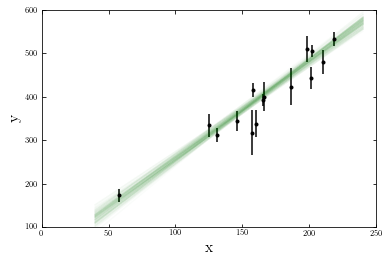

In [6]:
plt.errorbar(x, y, yerr=sigma_y, fmt=".k", capsize=0)
xGrid = np.linspace(40, 240)
# note that we are drawing 99 lines here, with m and b randomly sampled from w and V 
for m, b in np.random.multivariate_normal(w, V, size=99):
    plt.plot(xGrid, m*xGrid + b, "g", alpha=0.02)
plt.xlim(0, 250)
plt.ylim(100, 600)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)

Text(0, 0.5, 'b')

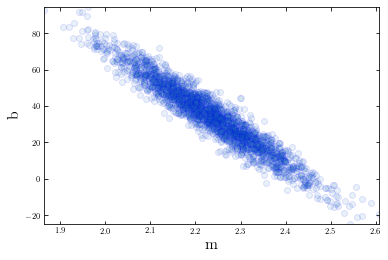

In [7]:
# let's visualize the covariance between m and b
a = np.random.multivariate_normal(w, V, size=2400)
plt.scatter(a[:,0], a[:,1], alpha=0.1)
plt.xlabel('m', fontsize=16)
plt.ylabel('b', fontsize=16) 

### Another approach: the probabilistic model

In order to perform posterior inference on a model and dataset, we need a function that computes the value of the posterior probability given a proposed setting of the parameters of the model. For reasons that will become clear below, we actually only need to return a value that is *proportional* to the probability.

The posterior probability for parameters $\mathbf{w} = (m,\,b)$ conditioned on a dataset $\mathbf{y}$ is given by

$$p(\mathbf{w} \,|\, \mathbf{y}) = \frac{p(\mathbf{y} \,|\, \mathbf{w}) \, p(\mathbf{w})}{p(\mathbf{y})}$$

where $p(\mathbf{y} \,|\, \mathbf{w})$ is the *likelihood* and $p(\mathbf{w})$ is the *prior*. For this example, we're modeling the likelihood by assuming that the datapoints are independent with known Gaussian uncertainties $\sigma_n$. This specifies a likelihood function:

$$p(\mathbf{y} \,|\, \mathbf{w}) = \prod_{n=1}^N \frac{1}{\sqrt{2\,\pi\,\sigma_n^2}} \,
\exp \left(-\frac{[y_n - f_\mathbf{w}(x_n)]^2}{2\,\sigma_n^2}\right)$$

where $f_\mathbf{w}(x) = m\,x + b$ is the linear model.

For numerical reasons, we will acutally want to compute the logarithm of the likelihood. In this case, this becomes:

$$\ln p(\mathbf{y} \,|\, \mathbf{w}) = -\frac{1}{2}\sum_{n=1}^N \frac{[y_n - f_\mathbf{w}(x_n)]^2}{\sigma_n^2} + \mathrm{constant} \quad.$$

By maxmizing $p(\mathbf{y} \,|\, \mathbf{w})$, we obtain posterior probability distributions for $m$ and $b$.

### Using astroML (or scikit-learn) to estimate the MLE for the parameters

We use a standardized form for the regression
- Define the regression model (clf = LinearRegression())
- Fit the model (clf.fit)
- Predict the values given the model (clf.predict)

Text(0, 0.5, 'y')

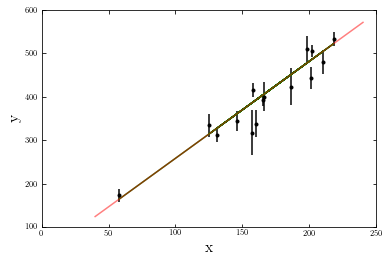

In [8]:
from astroML.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(x[:, None], y, sigma_y)
y_fit = clf.predict(x[:, None])

plt.errorbar(x, y, yerr=sigma_y, fmt=".k", capsize=0)
plt.plot(x, y_fit, "g", alpha=1)
plt.plot(xGrid, w[0]*xGrid + w[1], "r", alpha=0.5)
plt.xlim(0, 250)
plt.ylim(100, 600)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)

##  Total Least Squares regression <a id='totalLSQ'></a>
[Go to top](#toc)

What do we do if we have errors on the dependent and independent axes (or if the x axes errors are larger)?

### Exercise - using the approaches given above estimate the slope and intercept when the errors in x dominate

Text(0, 0.5, '$\\log \\Sigma_{SFR}\\ (M_\\odot\\ yr^{-1}\\ kpc^{-2})$')

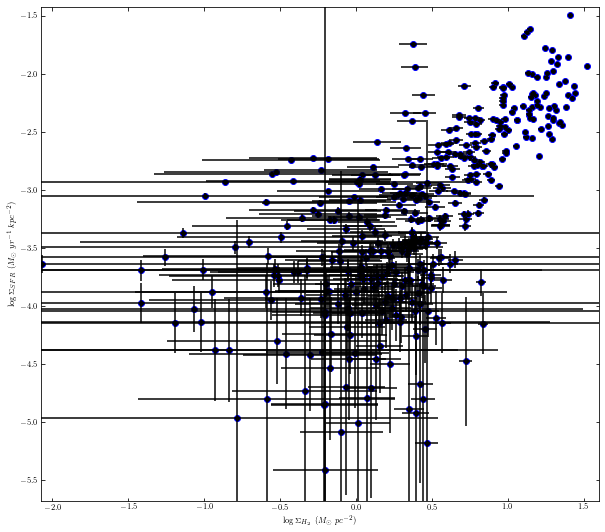

In [9]:
# read data and select training and cross validation sample
cal_x,cal_dx,cal_y,cal_dy = np.loadtxt("data/X_Y.clean.txt", skiprows=1, unpack=True)
cal_dxy=np.zeros(len(x))

# define classifiers
n_constraints = [2,]

# set plots
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(211)
plt.errorbar(cal_x, cal_y, yerr=cal_dy, xerr=cal_dx, fmt=".k", capsize=0)
ax.scatter(cal_x, cal_y,c='black')
ax.set_xlim(cal_x.min()/1.05,cal_x.max()*1.05)
ax.set_ylim(cal_y.min()*1.05,cal_y.max()/1.05)
ax.set_xlabel("$\log \Sigma_{H_2}\ (M_\odot\ pc^{-2})$")
ax.set_ylabel("$\log \Sigma_{SFR}\ (M_\odot\ yr^{-1}\ kpc^{-2})$")

### LSQ with uncertainties in both the dependent and independent axes 

In almost all real-world applications, the assumption that one
variable (the independent variable) is essentially free
from any uncertainty is not valid. Both the dependent and independent
variables will have measurement uncertainties (e.g. Tully-Fisher relations).

The impact of errors on the ``independent'' variables is a bias in the
derived regression coefficients. This is straightforward to show if
we consider a linear model with a dependent and independent
variable, $y^*$ and $x^*$. We can write the objective function as
before,

\begin{equation}
y^*_i=\theta_0 + \theta_1x^*_{i}.
\end{equation}

Now let us assume that we observe
$y$ and $x$, which are noisy
representations of $y^*$ and $x^*$, i.e.,
\begin{eqnarray}
x_i&=&x^*_i + \delta_i,\\
y_i &=& y^* + \epsilon_i,
\end{eqnarray}
with $\delta$ and $\epsilon$ centered normal distributions.

Solving for $y$ we get
\begin{equation}
      y=  \theta_0 + \theta_1 (x_i - \delta_i) +\epsilon_i.
\end{equation}

The uncertainty in $x$ is now part of the regression equation and
scales with the regression coefficients (biasing the regression
coefficient).  This problem is known in the statistics literature
as *total least squares* and belongs to the class of ``errors-in-variables''
problems.


For a detailed discussion of the solution to this problem, which is essentially
maximum likelihood estimation, please see
Chapter 8 in the reference book. Two other recommended references are
Hogg et al. (2010, astro-ph/1008.4686) and Kelly et al. (2011, astro-ph/1112.1745).


How can we account for the measurement uncertainties in both the
independent and dependent variables? Assuming they are Gaussian


> $ \Sigma_i = \left[
\begin{array}{cc}
\sigma_{x_i}^2 & \sigma_{xy_i} \\
\sigma_{xy_i} & \sigma_{y_i}^2
\end{array}
\right]
$

If we go back to the start of the lecture and write the equation for a line in terms of its normal vector 

> $ {\bf n} = \left [
\begin{array}{c}
-\sin \alpha\\
\cos \alpha\\
\end{array}
\right ] $

with $\theta_1 = \arctan(\alpha)$ and $\alpha$ is the angle
between the line and the $x$-axis. 

The covariance matrix projects onto
this space as
>$ S_i^2 = {\bf n}^T \Sigma_i {\bf n} $

and the  distance between a point and the line is

>$\Delta_i = {\bf n}^T
  z_i - \theta_0\ \cos \alpha, $
  
where $z_i$ represents the data point
>$(x_i,y_i)$.

The log-likelihood is then
>$ {\rm lnL} = - \sum_i \frac{\Delta_i^2}{2 S_i^2}$

and we can maximize the liklihood as a brute-force search or through MCMC

<b> THINKING OF A PROJECT: IT WOULD BE A REALLY INTERESTING PROBLEM TO EXTEND AND GENERALIZE THIS - IT WOULD GET A LOT OF CITATIONS!</b>

In [10]:
# Define some convenience functions

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse principal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))
        
# Find best-fit parameters
def get_best_fit(x, y, sigma_x, sigma_y, rho_xy):
    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))
    dX[:, 0, 0] = sigma_x ** 2
    dX[:, 1, 1] = sigma_y ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

    # note: TLS_logL was imported from astroML.linear_model 
    min_func = lambda beta: -TLS_logL(beta, X, dX)
    # this is optimization, not MCMC
    return optimize.fmin(min_func, x0=[-1, 1])


# plot results 
def plot_best_fit(x, y, sigma_x, sigma_y, rho_xy, beta_fit, mLSQ, bLSQ):
    fig = plt.figure(figsize=(8, 5))
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25, bottom=0.15, top=0.9)
    ax = fig.add_subplot(121)
    ax.scatter(x, y, c='k', s=9)
    plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)
    
    # plot the best-fit line
    m_fit, b_fit = get_m_b(beta_fit)
    x_fit = np.linspace(0, 300, 10)
    ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')
    ax.plot(x_fit, mLSQ * x_fit + bLSQ, '--', c='red')

    ax.set_xlim(40, 250)
    ax.set_ylim(100, 600)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    # plot the likelihood contour in m, b
    ax = fig.add_subplot(122)
    m = np.linspace(1.7, 2.8, 100)
    b = np.linspace(-60, 110, 100)
    logL = np.zeros((len(m), len(b)))

    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))
    dX[:, 0, 0] = sigma_x ** 2
    dX[:, 1, 1] = sigma_y ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y
    for i in range(len(m)):
        for j in range(len(b)):
            logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

    ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997), colors='k')
    ax.plot([-1000, 1000], [bLSQ, bLSQ], ':k', lw=1, c='red')
    ax.plot([mLSQ, mLSQ], [-1000, 1000], ':k', lw=1, c='red')

    ax.set_xlabel('slope')
    ax.set_ylabel('intercept')
    ax.set_xlim(1.7, 2.8)
    ax.set_ylim(-60, 110)

    plt.show()

In [13]:
# for comparison, let's get the standard LSQ solution - no errors
mux = np.mean(x)
muy = np.mean(y)
mLSQ = np.sum(x*y-mux*muy)/np.sum((x-mux)**2)
bLSQ = muy - mLSQ*mux
print('mLSQ=', mLSQ)
print('bLSQ=', bLSQ)

mLSQ= 2.191027996426704
bLSQ= 32.00396939102313


Optimization terminated successfully.
         Current function value: 56.688229
         Iterations: 85
         Function evaluations: 160
m= 2.299303276704902
b= 24.151505990843706


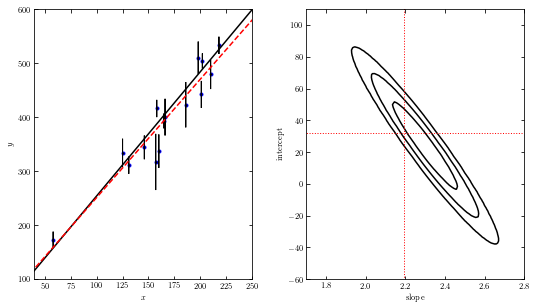

In [15]:
## let's do only errors in y - this is standard LSQ 
# Find best-fit parameters
err_x = 0*sigma_x
err_y = sigma_y
rho = 0*rho_xy
best_fit1 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit1, b_fit1 = get_m_b(best_fit1)
print('m=', m_fit1)
print('b=', b_fit1)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit1, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 72.220549
         Iterations: 171
         Function evaluations: 318
m= 2.596107117541477
b= -43.9768263126515


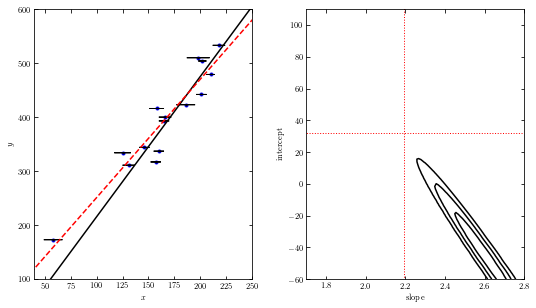

In [16]:
## now only errors in x; note that we could switch the axes and use standard LSQ
# Find best-fit parameters
err_x = sigma_x
err_y = 0*sigma_y
rho = rho_xy
best_fit2 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit2, b_fit2 = get_m_b(best_fit2)
print('m=', m_fit2)
print('b=', b_fit2)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit2, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 56.630031
         Iterations: 71
         Function evaluations: 136
m= 2.3849344880407286
b= 6.042234007073399


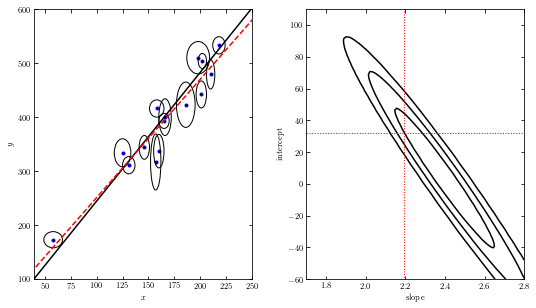

In [17]:
## errors in x and y, but without covariance
# Find best-fit parameters
err_x = sigma_x
err_y = sigma_y
rho = 0*rho_xy
best_fit3 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit3, b_fit3 = get_m_b(best_fit3)
print('m=', m_fit3)
print('b=', b_fit3)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit3, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164
m= 2.248785375229947
b= 27.930434942133815


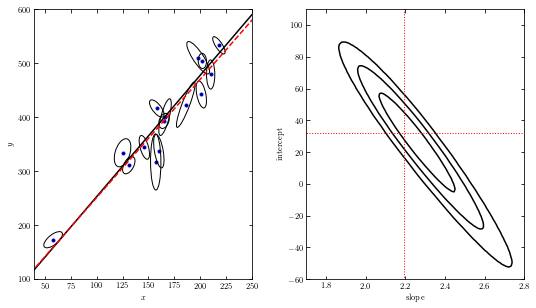

In [18]:
## errors in x and y with covariance
# Find best-fit parameters
err_x = sigma_x
err_y = sigma_y
rho = rho_xy
best_fit4 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit4, b_fit4 = get_m_b(best_fit4)
print('m=', m_fit4)
print('b=', b_fit4)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit4, mLSQ, bLSQ)

In [19]:
# compare all 4 versions and LSQ
print('m=', m_fit1, m_fit2, m_fit3, m_fit4, mLSQ)

m= 2.299303276704902 2.596107117541477 2.3849344880407286 2.248785375229947 2.191027996426704



### Using astroML


## Data sets used in the examples below

Use simulation data from [Kelly 2007](https://iopscience.iop.org/article/10.1086/519947/pdf). 
This simulator, called `simulation_kelly`  is available from `astroML.datasets`.

The function returns the $\xi_i$, $\eta_i$, $x_i$, $y_i$, $\epsilon_{x,i}$, $\epsilon_{y,i}$ and 
the input regression coefficients $\alpha$ and $\beta$ and intrinsic scatter $\epsilon$. 


A total of ``size`` values generated, measurement errors are scaled by parameters ``scalex`` and
 ``scaley`` following section 7.1 in [Kelly 2007](https://iopscience.iop.org/article/10.1086/519947/pdf).

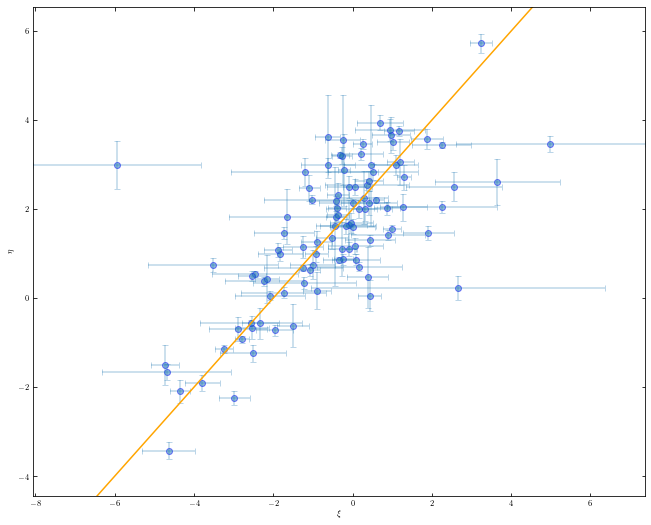

In [20]:
from astroML.datasets import simulation_kelly

ksi, eta, xi, yi, xi_error, yi_error, alpha_in, beta_in = simulation_kelly(size=100, scalex=0.2, scaley=0.2,
                                                                           alpha=2, beta=1, epsilon=(0, 0.75))

ksi_0 = np.arange(np.min(xi[0]) - 0.5, np.max(xi[0]) + 0.5)
eta_0 = alpha_in + ksi_0 * beta_in

figure = plt.figure(figsize=(10, 8))
figure.subplots_adjust(left=0.1, right=0.95,
                       bottom=0.1, top=0.95,
                       hspace=0.1, wspace=0.15)
ax = figure.add_subplot(111)
ax.scatter(xi[0], yi, alpha=0.5)
ax.errorbar(xi[0], yi, xerr=xi_error[0], yerr=yi_error, alpha=0.3, ls='')
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$\eta$')
ax.plot(ksi_0, eta_0, color='orange')

### Linear regression with uncertainties in both dependent and independent axes
 
The class ``LinearRegressionwithErrors`` can be used to take into account measurement errors in 
both the dependent and independent variables. 
The implementation relies on the [PyMC3](https://docs.pymc.io/) and [Theano](http://deeplearning.net/software/theano/)
packages. 

Note: The first initialization of the fitter is expected to take a couple of minutes, as ``Theano`` 
performs some code compilation for the underlying model. Sampling for consecutive runs is expected
to start up significantly faster.

In [21]:
from astroML.linear_model import LinearRegressionwithErrors
from astroML.plotting import  plot_regressions, plot_regression_from_trace

In [22]:
linreg_xy_err = LinearRegressionwithErrors()
linreg_xy_err.fit(xi, yi, yi_error, xi_error)

In [ ]:
plot_regressions(ksi, eta, xi[0], yi, xi_error[0], yi_error, add_regression_lines=True, alpha_in=alpha_in, beta_in=beta_in)
plot_regression_from_trace(linreg_xy_err, (xi, yi, xi_error, yi_error), ax=plt.gca(), chains=20)

## Multivariate regression
For multivariate data (where we fit a hyperplane rather than a straight line) we simply extend the description
of the regression function to multiple dimensions. The formalism used in the previous example becomes:


$$ \eta_i = \alpha + \beta^T \xi_i + \epsilon_i $$ 

where both $\beta^T$ and $\xi_i$ are now N-element vectors.

### Generate a dataset:

We use the same function as above to generate 100 datapoints in 2 dimensions. Note that the size of the ``beta`` 
parameter needs to match the dimensions.

In [54]:
ksi2, eta2, xi2, yi2, xi_error2, yi_error2, alpha_in2, beta_in2 = simulation_kelly(size=100, scalex=0.2, scaley=0.2,
                                                                                   alpha=2, beta=[0.5, 1],
                                                                                   multidim=2)

The previously used ``LinearRegressionwithErrors`` class can be used with multidimensional data, thus the fitting is done the exact same way as before:

In [ ]:
linreg_xy_err2 = LinearRegressionwithErrors()
linreg_xy_err2.fit(xi2, yi2, yi_error2, xi_error2)

There are several ways to explore the fits, in the following we show a few ways to plot this dataset. As in this example the fitted hyperplane was 2D, we can use a 3D plot to show both the fit and the underlying regession we used to generate the data from. In this 3D plot, the blue plane is the true regression, while the red plane is our fit, that takes into account the errors on the data points.

Other plotting libraries can also be used to e.g. create pairplots of the parameters (e.g. Arviz' ``plot_pair`` function, or Seaborn's ``jointplot``).

In [ ]:
x0 = np.linspace(np.min(xi2[0])-0.5, np.max(xi2[0])+0.5, 50)
x1 = np.linspace(np.min(xi2[1])-0.5, np.max(xi2[1])+0.5, 50)
x0, x1 = np.meshgrid(x0, x1)

y0 = alpha_in + x0 * beta_in2[0] + x1 * beta_in2[1]

y_fitted = linreg_xy_err2.coef_[0] + x0 * linreg_xy_err2.coef_[1] + x1 * linreg_xy_err2.coef_[2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('xi2[0] ')
ax.set_ylabel('xi2[1] ')
ax.set_zlabel('yi2 ')
ax.scatter(xi2[0], xi2[1], yi2, s=20)
ax.plot_surface(x0, x1, y0, alpha=0.2, facecolor='blue', label='True regression')
ax.plot_surface(x0, x1, y_fitted, alpha=0.2, facecolor='red', label='Fitted regression')

### Sampler statistics and traceplots

The PyMC3 trace is available in the ``.trace`` attribute of the class instances (e.g. ``linreg_xy_err2.trace`` in the previous example), after we performed the fit. This can be then used for checking for convergence, and generating statistics for the samples. We would refer to use the tools provided by PyMC3, e.g. the ``traceplot()`` that takes the trace object as its input. Note that in the multidimensional case, there will be multiple ``ksi`` and ``slope`` traces in aggreement with the dimensionality of the input ``xi`` data, in the ``traceplot`` they are plotted with different colours.

In [ ]:
import pymc3 as pm
matplotlib.rc('text', usetex=False)

pm.traceplot(linreg_xy_err2.trace)

### CONCLUSION

Beware of your measurement uncertainties, especially if both variables have them!

##  Dealing with outliers <a id='outliers'></a>
[Go to top](#toc)


The $L_2$ ($\sum_{i=1}^N (y_i - M(x_i))^2$) norm is sensitive to outliers (i.e. it squares the residuals). A number of approaches exist for correcting for outliers. These include "sigma-clipping", using interquartile ranges, taking the median of solutions of subsets of the data, and least trimmed squares (which searchs for the subset of points that minimizes $\sum_i^K (y_i - \theta_ix_i)^2$).


We can also change the **loss function** or **likelihood** to reduce the weight of outliers. An example of this is known as the _Huber loss function_

> $
\sum_{i=1}^N e(y_i|y),
$

where

>$
e(t) = \left\{
\begin{array}{ll}
\frac{1}{2} t^2 & \mbox{if} \; |t| \leq c, \\
c|t| - \frac{1}{2} c^2 & \mbox{if} \; |t| \geq c,
\end{array}
\right )
$

this is continuous and differentiable and transitions to an $L_1$ norm ($\sum_{i=1}^N |y_i - M(x_i)|$) for large excursions

![title](https://upload.wikimedia.org/wikipedia/commons/c/cc/Huber_loss.svg)


Text(0, 0.5, '$y$')

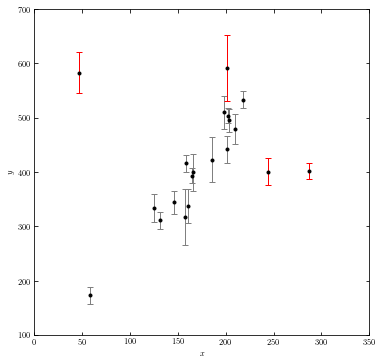

In [23]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from scipy import optimize

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.errorbar(x[4:], y[4:], dy[4:], fmt='.k', lw=1, ecolor='gray')
ax.errorbar(x[:4], y[:4], dy[:4], fmt='.k', lw=1, ecolor='red')
ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

Optimization terminated successfully.
         Current function value: 18.680770
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 59
         Function evaluations: 115


Text(0, 0.5, '$y$')

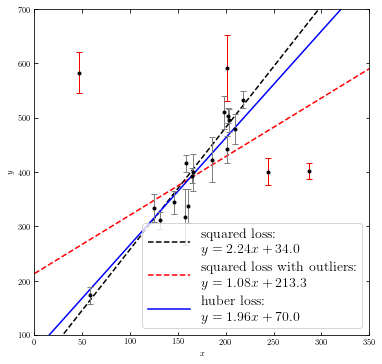

In [24]:
# Define the standard squared-loss function
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)


# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=2):
    y_fit = m * x + b
    t = abs((y - y_fit) / dy)
    flag = t > c
    return np.sum((~flag) * (0.5 * t ** 2) - (flag) * c * (0.5 * c - t), -1)

f_squared = lambda beta: squared_loss(beta[0], beta[1], x=x[4:], y=y[4:], dy=dy[4:])

f_squared_outlier = lambda beta: squared_loss(beta[0], beta[1], x=x, y=y, dy=dy)

f_huber = lambda beta: huber_loss(beta[0], beta[1], x=x, y=y, dy=dy, c=1)

#------------------------------------------------------------
# compute the maximum likelihood using the huber loss
beta0 = (2, 30)
beta_squared = optimize.fmin(f_squared, beta0)
beta_squared_outlier = optimize.fmin(f_squared_outlier, beta0)

beta_huber = optimize.fmin(f_huber, beta0)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], '--k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], '--k', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], '-k', color='blue',
        label="huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))
ax.legend(loc=4, prop=dict(size=14))

ax.errorbar(x[4:], y[4:], dy[4:], fmt='.k', lw=1, ecolor='gray')
ax.errorbar(x[:4], y[:4], dy[:4], fmt='.k', lw=1, ecolor='red')


ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

###  From a Bayesian Perspective


We can assume the data are drawn from two Gaussians error distribution (one for the function and the other for the outliers)

$\begin{eqnarray}
&  p(\{y_i\}|\{x_i\}, \{\sigma_i\}, \theta_0, \theta_1, \mu_b, V_b, p_b)
  \propto \nonumber\\
&  \prod_{i=1}^{N} \bigg[
    \frac{1-p_b}{\sqrt{2\pi\sigma_i^2}}
      \exp\left(-\frac{(y_i - \theta_1 x_i - \theta_0)^2}
               {2 \sigma_i^2}\right)
    + \frac{p_b}{\sqrt{2\pi(V_b + \sigma_i^2)}}
    \exp\left(-\frac{(y_i - \mu_b)^2}{2(V_b + \sigma_i^2)}\right)
    \bigg].
\end{eqnarray}
$

$V_b$ is the variance of the outlier distribution. If we use MCMC we can marginalize over the nuisance  parameters $p_b$, $V_b$, $\mu_b$. We could also calculate the probability that a point is drawn from the outlier or "model" Gaussian.




In [25]:
import numpy as np

import pymc3 as pm

from matplotlib import pyplot as plt
from theano import shared as tshared
import theano.tensor as tt

from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev


# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

np.random.seed(0)

# ------------------------------------------------------------
# Get data: this includes outliers. We need to convert them to Theano variables
data = fetch_hogg2010test()
xi = tshared(data['x'])
yi = tshared(data['y'])
dyi = tshared(data['sigma_y'])
size = len(data)


# ----------------------------------------------------------------------
# Define basic linear model

def model(xi, theta, intercept):
    slope = np.tan(theta)
    return slope * xi + intercept


# ----------------------------------------------------------------------
# First model: no outlier correction
with pm.Model():
    # set priors on model gradient and y-intercept
    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    y = pm.Normal('y', mu=model(xi, theta, inter), sd=dyi, observed=yi)

    trace0 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Second model: nuisance variables correcting for outliers
# This is the mixture model given in equation 17 in Hogg et al
def mixture_likelihood(yi, xi):
    """Equation 17 of Hogg 2010"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi * np.exp(-0.5 * (yi - mu) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return tt.sum(tt.log((1 - Pb) * L_in + Pb * L_out))


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -200, 400)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2, testval=np.pi / 4)

    y_mixture = pm.DensityDist('mixturenormal', logp=mixture_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace1 = pm.sample(draws=5000, tune=1000)


# ----------------------------------------------------------------------
# Third model: marginalizes over the probability that each point is an outlier.
# define priors on beta = (slope, intercept)

def outlier_likelihood(yi, xi):
    """likelihood for full outlier posterior"""

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    logL_in = -0.5 * tt.sum(qi * (np.log(2 * np.pi * Vi)
                                  + (yi - mu) ** 2 / Vi))

    logL_out = -0.5 * tt.sum((1 - qi) * (np.log(2 * np.pi * (Vi + Vb))
                                         + (yi - Yb) ** 2 / (Vi + Vb)))

    return logL_out + logL_in


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    # qi is bernoulli distributed
    qi = pm.Bernoulli('qi', p=1 - Pb, shape=size)

    y_outlier = pm.DensityDist('outliernormal', logp=outlier_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace2 = pm.sample(draws=5000, tune=1000)


# ------------------------------------------------------------
# plot the data
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(data['x'], data['y'], data['sigma_y'], fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

#------------------------------------------------------------
# Go through models; compute and plot likelihoods
linestyles = [':', '--', '-']
labels = ['no outlier correction\n(dotted fit)',
          'mixture model\n(dashed fit)',
          'outlier rejection\n(solid fit)']

x = np.linspace(0, 350, 10)

bins = [(np.linspace(140, 300, 51), np.linspace(0.6, 1.6, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51))]

for i, trace in enumerate([trace0, trace1, trace2]):
    H2D, bins1, bins2 = np.histogram2d(np.tan(trace['theta']),
                                       trace['inter'], bins=50)
    w = np.where(H2D == H2D.max())

    # choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    # plot the best-fit line
    ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

    # For the model which identifies bad points,
    # plot circles around points identified as outliers.
    if i == 2:
        Pi = trace['qi'].mean(0)
        outlier_x = data['x'][Pi < 0.32]
        outlier_y = data['y'][Pi < 0.32]
        ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                    facecolors='none', edgecolors='red')

    # plot the likelihood contours
    ax = plt.subplot(222 + i)

    H, xbins, ybins = np.histogram2d(trace['inter'],
                                     np.tan(trace['theta']), bins=bins[i])
    H[H == 0] = 1E-16
    Nsigma = convert_to_stdev(np.log(H))

    ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
               0.5 * (ybins[1:] + ybins[:-1]),
               Nsigma.T, levels=[0.683, 0.955], colors='black')

    ax.set_xlabel('intercept')
    ax.set_ylabel('slope')
    ax.grid(color='gray')
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

    ax.text(0.96, 0.96, labels[i], ha='right', va='top',
            bbox=dict(fc='w', ec='none', alpha=0.5),
            transform=ax.transAxes)
    ax.set_xlim(bins[i][0][0], bins[i][0][-1])
    ax.set_ylim(bins[i][1][0], bins[i][1][-1])

ax1.set_xlim(0, 350)
ax1.set_ylim(100, 700)

plt.show()

### Exercise - using the approaches given above estimate the slope and intercept when the errors are in both axes